In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from gw_signal_tools.waveform import get_wf_generator, optimize_overlap
from gw_signal_tools.fisher import FisherMatrix, FisherMatrixNetwork

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [2]:
from gw_signal_tools import PLOT_STYLE_SHEET
plt.style.use(PLOT_STYLE_SHEET)

In [3]:
# f_min = 20.*u.Hz  # Cutoff frequency -> usual cutoff
# f_min = 25.*u.Hz  # Cutoff frequency for 50 Msun
f_min = 15.*u.Hz  # Cutoff frequency for 100 Msun
f_max = 1024. * u.Hz  # Cutoff from PSD
delta_f = 2**-6 * u.Hz
delta_t = 1./4096.*u.s
f_ref = f_min  # Frequency where we specify spins
# f_ref = 0.8*f_min  # Frequency where we specify spins
# f_ref = 1.2*f_min  # Frequency where we specify spins


wf_params = {
    # 'total_mass': 50.*u.Msun,
    'total_mass': 100.*u.Msun,  # To get into range of NRSur validity (above 60)
    # 'mass_ratio': 0.05*u.dimensionless_unscaled,
    # 'mass_ratio': 0.15*u.dimensionless_unscaled,
    'mass_ratio': 0.5*u.dimensionless_unscaled,
    'f22_start': f_min,
    'f_max': f_max,
    'deltaF': delta_f,
    'f22_ref': f_ref,
    'phi_ref': 0.*u.rad,
    # 'distance': 1.*u.Mpc,
    'distance': 440.*u.Mpc,  # As expected, systematic error is independent of SNR and thus amplitude given by D_L
    'inclination': 0.*u.rad,
    'eccentricity': 0.*u.dimensionless_unscaled,
    'longAscNodes': 0.*u.rad,
    'meanPerAno': 0.*u.rad,
    'condition': 0
}

In [4]:
# Make sure mass1 and mass2 are not in default_dict (makes messy behaviour)
import lalsimulation.gwsignal.core.parameter_conventions as pc
pc.default_dict.pop('mass1', None);
pc.default_dict.pop('mass2', None);

# Fisher Matrix Testing

## Calls with different waveform models

Note: this evaluation takes a lot of time! -> huh, seems to depend strongly on chosen mass value (and maybe whether mass ratio is included). Now it is perfectly fine

In [5]:
for model in ['IMRPhenomXPHM', 'SEOBNRv4PHM', 'NRSur7dq4']:
    wf_gen = get_wf_generator(model)
    
    globals()[f'fisher_{model}'] = FisherMatrix(
        wf_params | {'condition': 1},
        # ['total_mass', 'mass_ratio', 'time', 'phase'],
        ['total_mass', 'time', 'phase'],
        wf_gen,
        min_dt_prec=1e-5*u.s,
        deriv_routine='numdifftools'
    )

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XL

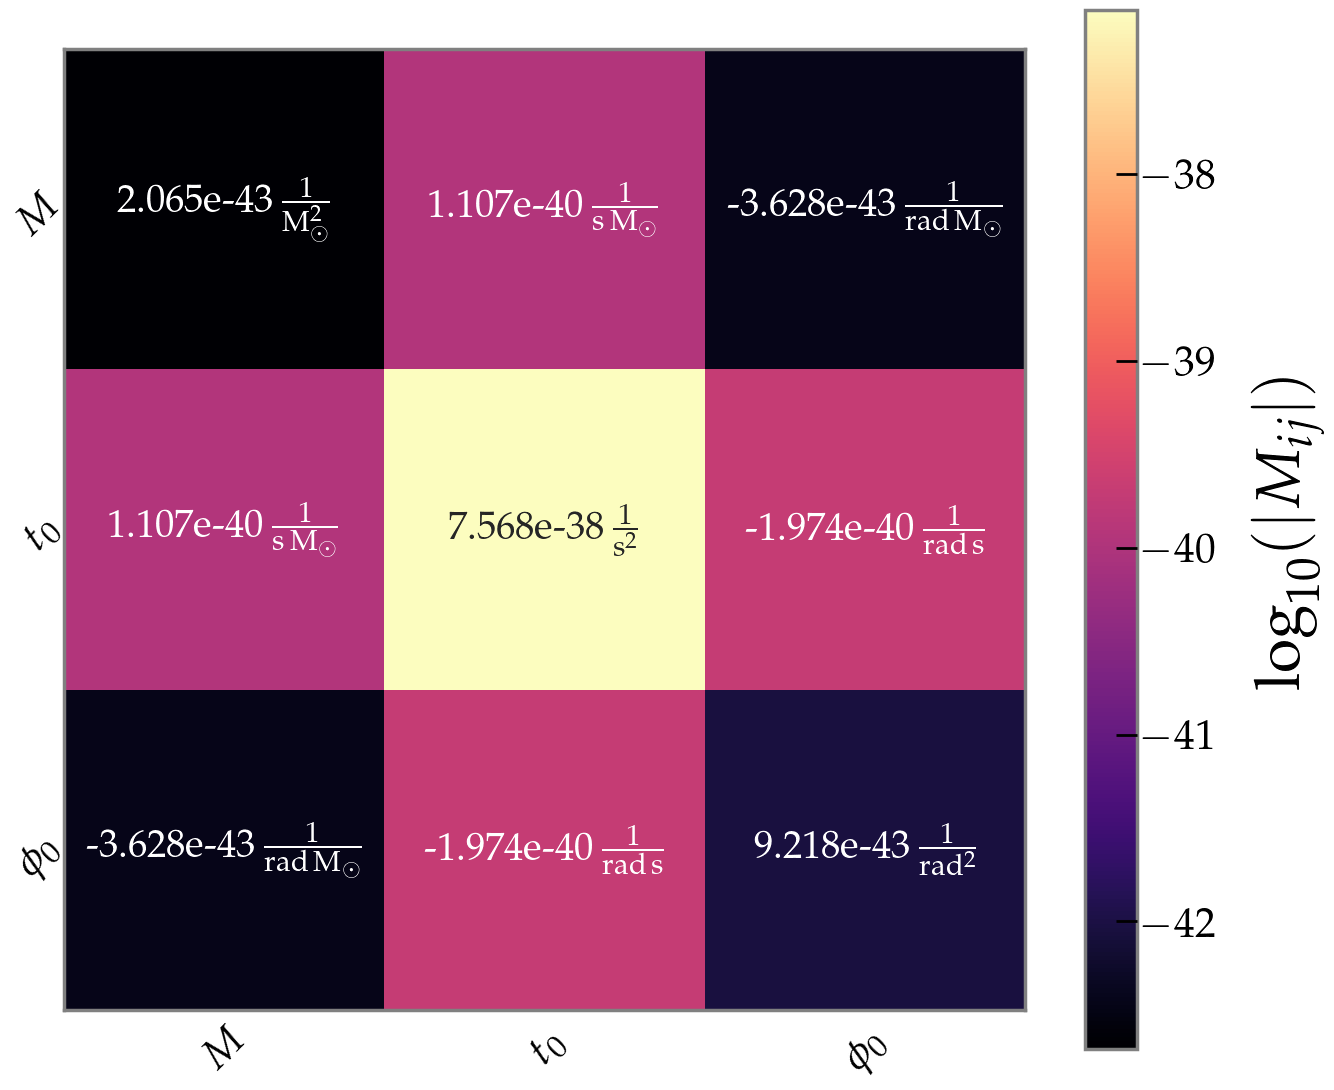

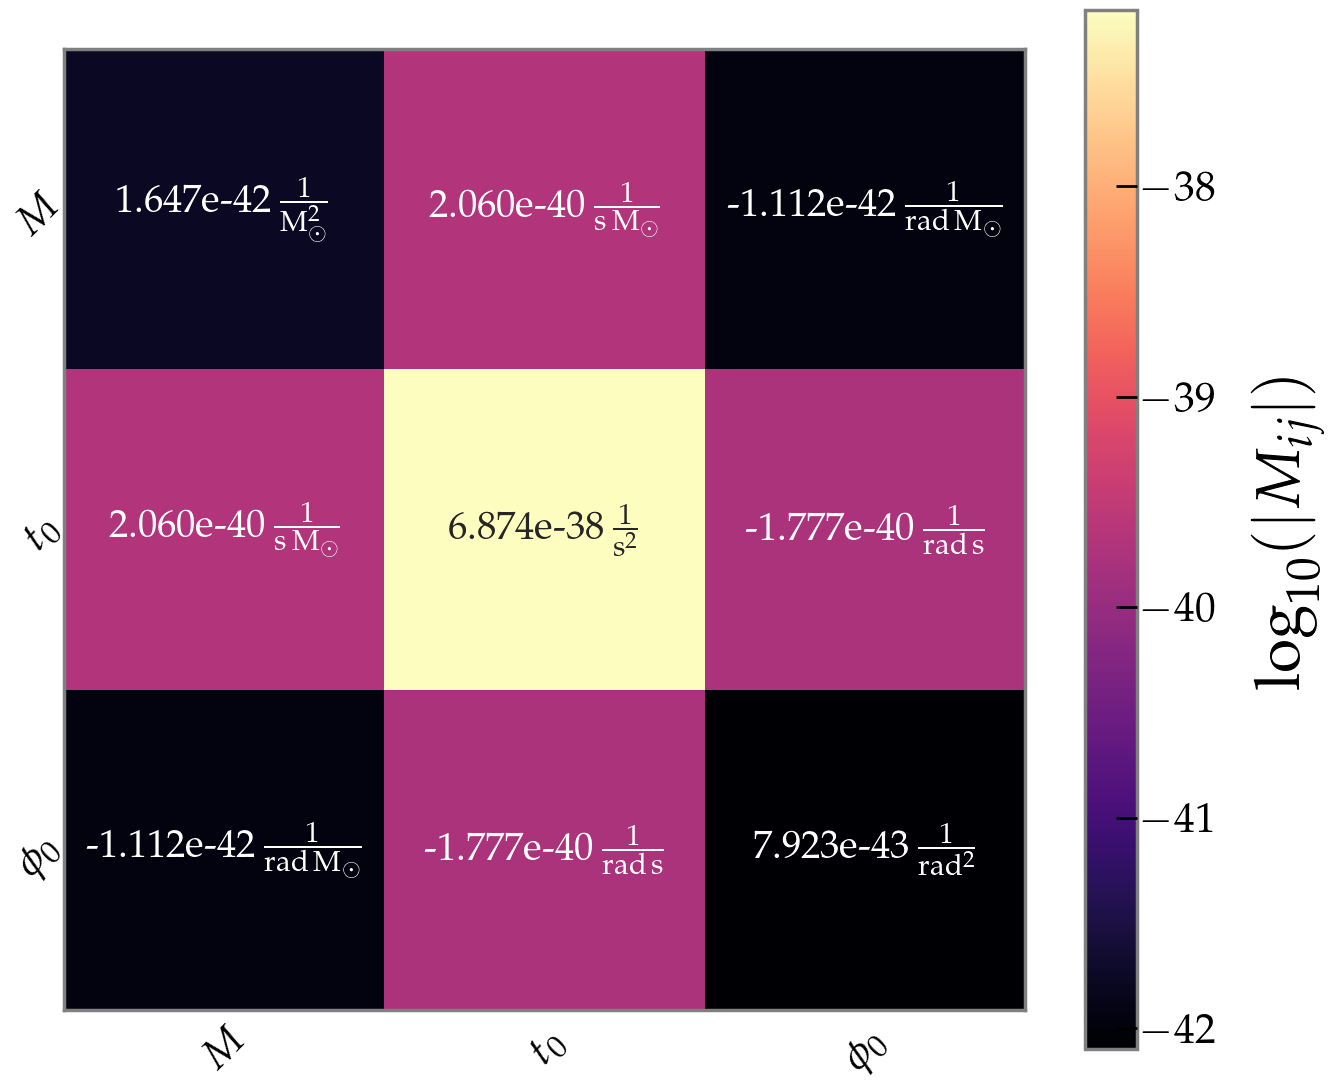

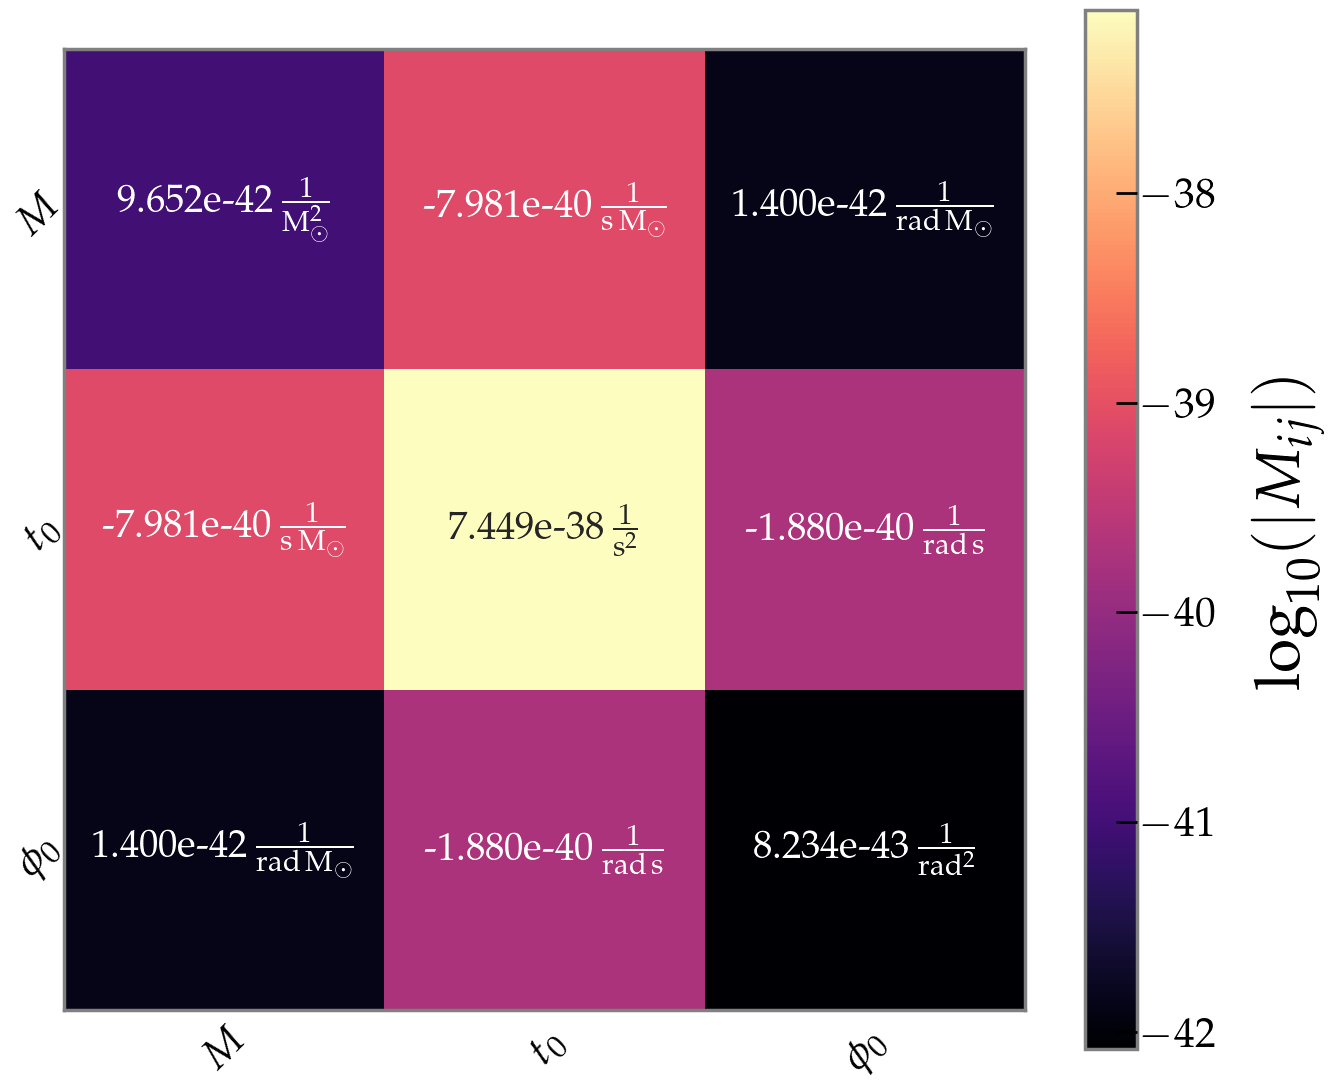

In [6]:
for model in ['IMRPhenomXPHM', 'SEOBNRv4PHM', 'NRSur7dq4']:
    fisher = globals()[f'fisher_{model}']

    # print(fisher.fisher)

    fig, ax = plt.subplots(figsize=(fisher.nparams*4.5 + 2, fisher.nparams*4.5))
    fisher.plot_matrix(fisher.fisher, ax=ax)

    # fisher.plot_matrix(fisher.fisher / fisher_IMRPhenomXPHM.fisher - 1., ax=ax)
    # fisher.plot_matrix(fisher.fisher / fisher_SEOBNRv4PHM.fisher - 1., ax=ax)
    # fisher.plot_matrix(fisher.fisher / fisher_NRSur7dq4.fisher - 1., ax=ax)

    plt.show()

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


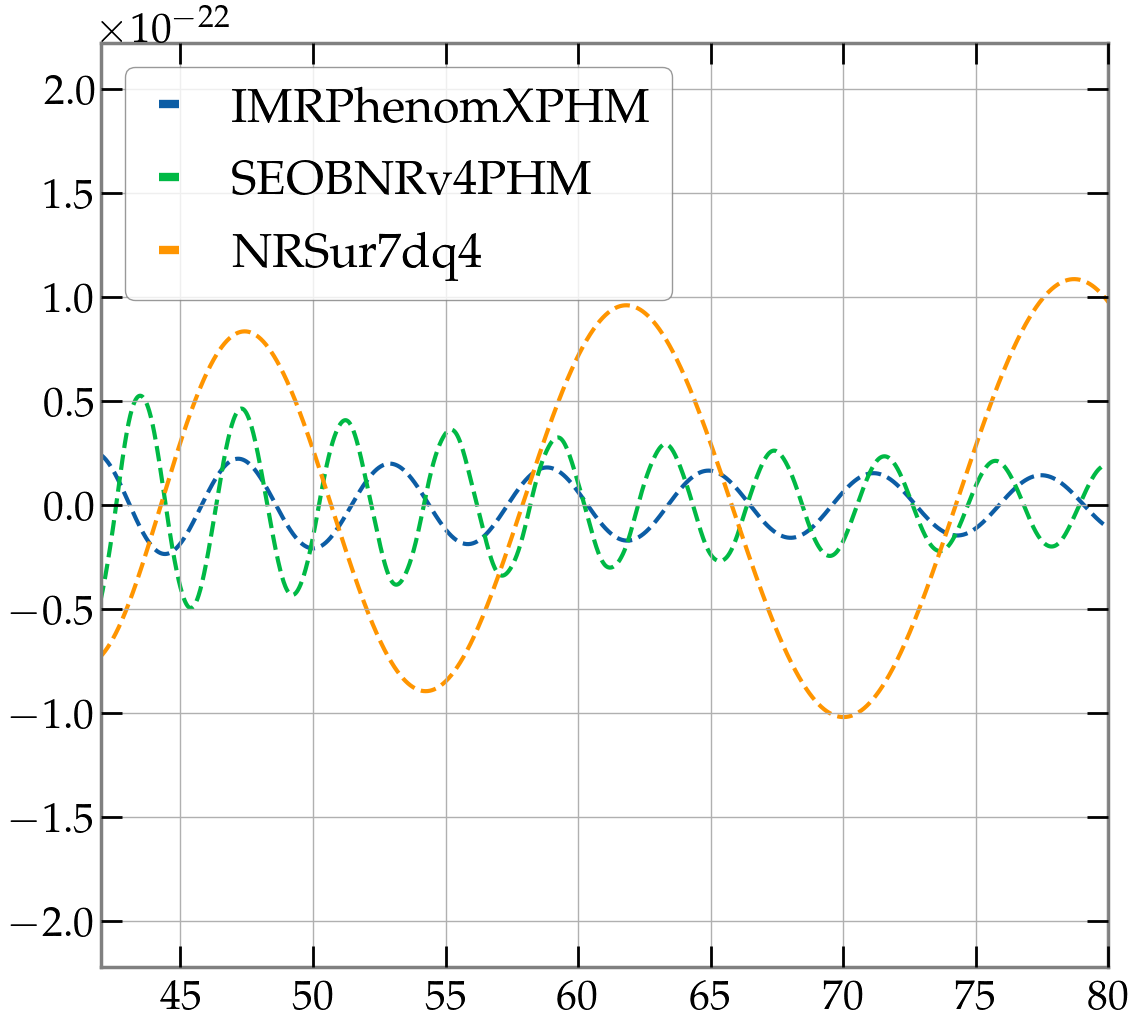

In [7]:
for model in ['IMRPhenomXPHM', 'SEOBNRv4PHM', 'NRSur7dq4']:
    fisher = globals()[f'fisher_{model}']

    param = 'total_mass'
    # param = 'mass_ratio'
    # param = 'time'
    # param = 'phase'

    plt.plot(fisher.deriv_info[param]['deriv'], '--', label=model)


plt.legend()
# plt.xlim(20, 62)
plt.xlim(42, 80)

plt.show()

This is not because of conditioning, checked that. So really conventional difference

EOB derivative looks strange for some mass values

In [13]:
M_shift = 0.2*u.Msun
# M_shift = 0.4*u.Msun
# M_shift = 4*u.Msun

for model in ['IMRPhenomXPHM', 'SEOBNRv4PHM', 'NRSur7dq4']:
    fisher = globals()[f'fisher_{model}']

    wf_gen = get_wf_generator(model)

    def wf_gen_shifted(wf_params):
        _wf_params = wf_params.copy()
        _wf_params['total_mass'] = _wf_params['total_mass'] + M_shift

        return wf_gen(_wf_params)

    globals()[f'sys_bias_{model}'] = fisher.systematic_bias(
        wf_gen_shifted,
        # optimize=False,
        optimize=['time', 'phase'],
        min_dt_prec=1e-5*u.s
    )

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XL

In [14]:
print(sys_bias_IMRPhenomXPHM)
print(sys_bias_SEOBNRv4PHM)
print(sys_bias_NRSur7dq4)

array([[<Quantity 0.19959049 solMass>],
       [<Quantity -4.08728019e-07 s>],
       [<Quantity -8.14080678e-06 rad>]], dtype=object)
array([[<Quantity 0.1998696 solMass>],
       [<Quantity 0.00023333 s>],
       [<Quantity 0.00061341 rad>]], dtype=object)
array([[<Quantity 0.19896604 solMass>],
       [<Quantity 0.00296236 s>],
       [<Quantity 0.00247598 rad>]], dtype=object)


Recovery using Phenom does not depend on whether conditioning is switched on or not, good.

SEOB is constantly about an order of magnitude below real value. -> hmmm also depends on value of total mass, now is fine

In [11]:
nrsur_gen = get_wf_generator('NRSur7dq4')

def nrsur_shifted(wf_params):
    _wf_params = wf_params.copy()
    _wf_params['total_mass'] = _wf_params['total_mass'] + M_shift

    return nrsur_gen(_wf_params)

sys_bias_phenom_nrsur = fisher_IMRPhenomXPHM.systematic_bias(
    nrsur_gen,
    # optimize=False,
    optimize=['time', 'phase'],
    min_dt_prec=1e-5*u.s
)

sys_bias_phenom_nrsur_shifted = fisher_IMRPhenomXPHM.systematic_bias(
    nrsur_shifted,
    # optimize=False,
    optimize=['time', 'phase'],
    min_dt_prec=1e-5*u.s
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [12]:
print(sys_bias_phenom_nrsur.T)
print(sys_bias_phenom_nrsur_shifted.T)

array([[<Quantity 0.00561325 solMass>, <Quantity 0.10072479 s>,
        <Quantity 1.50473982 rad>]], dtype=object)
array([[<Quantity 0.14150212 solMass>, <Quantity 0.10054123 s>,
        <Quantity 1.18376246 rad>]], dtype=object)


Alright, accuracy of performance degrades. And is not necessarily due to huge biases between the models, as first result shows.

-> we should probably go higher in total mass for things to work here. NRSur calibration is not guaranteed at 50 solar masses

In [20]:
eob_gen = get_wf_generator('SEOBNRv4PHM')

def eob_shifted(wf_params):
    _wf_params = wf_params.copy()
    _wf_params['total_mass'] = _wf_params['total_mass'] + M_shift

    return eob_gen(_wf_params)

sys_bias_phenom_eob = fisher_IMRPhenomXPHM.systematic_bias(
    eob_gen,
    # optimize=False,
    optimize=['time', 'phase'],
    min_dt_prec=1e-5*u.s
)

sys_bias_phenom_eob_shifted = fisher_IMRPhenomXPHM.systematic_bias(
    eob_shifted,
    # optimize=False,
    optimize=['time', 'phase'],
    min_dt_prec=1e-5*u.s
)

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XL

In [16]:
print(sys_bias_phenom_eob.T)
print(sys_bias_phenom_eob_shifted.T)

array([[<Quantity 0.26555163 solMass>, <Quantity -0.0805258 s>,
        <Quantity 1.2628017 rad>]], dtype=object)
array([[<Quantity 0.39612875 solMass>,
        <Quantity -0.08072114 s>, <Quantity 0.94021145 rad>]],
      dtype=object)


In [23]:
eob_gen = get_wf_generator('SEOBNRv4PHM')

def eob_shifted(wf_params):
    _wf_params = wf_params.copy()
    _wf_params['total_mass'] = _wf_params['total_mass'] + M_shift

    return eob_gen(_wf_params)

sys_bias_nrsur_eob = fisher_NRSur7dq4.systematic_bias(
    eob_gen,
    # optimize=False,
    optimize=['time', 'phase'],
    min_dt_prec=1e-5*u.s
)

sys_bias_nrsur_eob_shifted = fisher_NRSur7dq4.systematic_bias(
    eob_shifted,
    # optimize=False,
    optimize=['time', 'phase'],
    min_dt_prec=1e-5*u.s
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [24]:
print(sys_bias_nrsur_eob.T)
print(sys_bias_nrsur_eob_shifted.T)

array([[<Quantity 0.36909473 solMass>,
        <Quantity -0.17540607 s>, <Quantity 0.35725713 rad>]],
      dtype=object)
array([[<Quantity 0.56137646 solMass>,
        <Quantity -0.17256165 s>, <Quantity 0.34746879 rad>]],
      dtype=object)


Bias difference is pretty much exactly 0.2, but I have no idea why initial value is so high

## Recovering $t_0$-Bias

In [ ]:
# -- Ensure consistency with previous outputs
wf_params['total_mass'] = 50*u.Msun
wf_params['f_max'] = 20.*u.Hz
wf_params['f_ref'] = 20.*u.Hz

In [5]:
ref_model = 'IMRPhenomXPHM'

ref_generator = get_wf_generator(ref_model)

/home/user/miniconda3/envs/gw_signal_tools_light/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


In [6]:
t_shift = 1e-3*u.s

def shifted_wf_gen(wf_params):
    wf = ref_generator(wf_params)
    return wf * np.exp(-2.j*np.pi*wf.frequencies*t_shift)

In [7]:
wf1_shifted, wf2_shifted, opt_params = optimize_overlap(
    wf_params,
    ref_generator,
    shifted_wf_gen,
    opt_params=['time', 'phase'],
    # opt_params=['time'],
    min_dt_prec=1e-5
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [8]:
fisher_t_bias = FisherMatrix(
    wf_params,
    ['time', 'phase'],
    # 'time',
    shifted_wf_gen,
    direct_computation=False,
    min_dt_prec=1e-5*u.s
)

sys_bias_t_bias_non_opt = fisher_t_bias.systematic_bias(
    ref_generator,
    optimize=False
)


sys_bias_t_bias_opt, opt_info = fisher_t_bias.systematic_bias(
    ref_generator,
    # optimize=['time', 'phase'],
    optimize=['time'],
    # Results for both choices are equal,
    return_opt_info=True
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [9]:
print(t_shift)
print(opt_params['time'])
print(sys_bias_t_bias_non_opt[0,0])
print(sys_bias_t_bias_opt[0,0])

0.001 s
-0.00099945068359375 s
-0.0005971830525189386 s
-0.0009999999999211048 s


In [10]:
# t_shift_from_opt = []
# t_bias_non_opt = []
# t_bias_opt = []

# # t_shifts = np.linspace(1e-6, 1e-2, num=16)*u.s
# t_shifts = 10**np.linspace(-6, -2, num=16)*u.s
# # t_shifts = np.linspace(1e-6, 1e-3, num=12)*u.s


# wf1 = ref_generator(wf_params)

# for shift in t_shifts:
#     # def shifted_wf_gen(wf_params):
#     #     wf = ref_generator(wf_params)
#     #     # return wf * np.exp(-2.j*np.pi*wf.frequencies*shift)
#     #     return wf * np.exp(-2.j*np.pi*wf.frequencies*(-shift))  # To have same in plot
    

#     # _, _, opt_params = optimize_overlap(
#     #     wf_params,
#     #     ref_generator,
#     #     shifted_wf_gen,
#     #     opt_params=['time', 'phase'],
#     #     min_dt_prec=1e-5*u.s
#     # )

#     # t_shift_from_opt += [
#     #     opt_params['time'].value  # Otherwise error when reshaping
#     # ]
#     # Kind of unnecessary, optimization in sys error does same

    
#     # fisher = FisherMatrix(
#     #     wf_params,
#     #     ['time', 'phase'],
#     #     # 'time',
#     #     shifted_wf_gen,
#     #     direct_computation=False,
#     #     min_dt_prec=1e-5*u.s
#     # )
    
#     # t_bias_non_opt += [
#     #     fisher.systematic_bias(
#     #         ref_generator,
#     #         'time',
#     #         optimize=False
#     #     )
#     # ]
    
#     # t_bias_opt += [
#     #     fisher.systematic_bias(
#     #         ref_generator,
#     #         'time',
#     #         # optimize=True,  # Equivalent, but less explicit than below
#     #         optimize=['time', 'phase'],
#     #         return_opt_info=False
#     #     )
#     # ]


#     # Testing sign from Potsdam paper, where shifted by +shift is reference
#     # -> should be equivalent to our tests, where we shift biased WF
#     #    by -shift (it is, luckily)
#     def shifted_wf_gen(wf_params):
#         wf = ref_generator(wf_params)
#         return wf * np.exp(-2.j*np.pi*wf.frequencies*shift)
#         # return wf * np.exp(-2.j*np.pi*wf.frequencies*(-shift))  # To have same in plot
    

#     fisher = FisherMatrix(
#         wf_params,
#         ['time', 'phase'],
#         # 'time',
#         ref_generator,
#         direct_computation=False,
#         min_dt_prec=1e-5*u.s
#     )
    
#     t_bias_non_opt += [
#         fisher.systematic_bias(
#             shifted_wf_gen,
#             'time',
#             optimize=False
#         )
#     ]
    
#     t_bias_opt += [
#         fisher.systematic_bias(
#             shifted_wf_gen,
#             'time',
#             # optimize=True,  # Equivalent, but less explicit than below
#             optimize=['time', 'phase'],
#             return_opt_info=False
#         )
#     ]

# t_bias_non_opt = np.reshape(t_bias_non_opt, -1)
# t_bias_opt = np.reshape(t_bias_opt, -1)
# t_shift_from_opt = np.reshape(t_shift_from_opt, -1)

In [11]:
t_shift_from_opt = []
t_bias_non_opt = []
t_bias_opt_v1 = []
t_bias_opt_v2 = []
t_bias_opt_v3 = []

t_shifts = 10**np.linspace(-6, -2, num=16)*u.s


wf1 = ref_generator(wf_params)

for shift in t_shifts:
    def shifted_wf_gen(wf_params):
        wf = ref_generator(wf_params)
        return wf * np.exp(-2.j*np.pi*wf.frequencies*shift)
        # return wf * np.exp(-2.j*np.pi*wf.frequencies*(-shift))  # To have same in plot
    

    fisher = FisherMatrix(
        # wf_params,
        wf_params | {'deltaF': 2**-2*u.Hz},
        'time',
        ref_generator,
        direct_computation=False,
        # min_dt_prec=1e-5*u.s,
        df=2**-2,
        min_dt_prec=1e-6*u.s
    )
    
    t_bias_non_opt += [
        fisher.systematic_bias(
            shifted_wf_gen,
            'time',
            optimize=False
        )
    ]
    
    t_bias_opt_v1 += [
        fisher.systematic_bias(
            shifted_wf_gen,
            'time',
            # optimize=True,  # Equivalent, but less explicit than below
            # optimize=['time', 'phase'],
            optimize=['time'],  # Otherwise we have impact of slight degeneracy between time, phase in overlap optimization, but not in sys error formula (inconsistent)
            return_opt_info=False
        )
    ]
    
    t_bias_opt_v2 += [
        fisher.systematic_bias(
            shifted_wf_gen,
            'time',
            # optimize=True,  # Equivalent, but less explicit than below
            optimize=['time', 'phase'],
            # optimize=['time'],  # Otherwise we have impact of slight degeneracy between time, phase in overlap optimization, but not in sys error formula (inconsistent)
            return_opt_info=False
        )
    ]


    fisher = FisherMatrix(
        # wf_params,
        wf_params | {'deltaF': 2**-2*u.Hz},
        ['time', 'phase'],
        ref_generator,
        direct_computation=False,
        # min_dt_prec=1e-5*u.s,
        df=2**-2,
        min_dt_prec=1e-6*u.s
    )
    
    t_bias_opt_v3 += [
        fisher.systematic_bias(
            shifted_wf_gen,
            'time',
            # optimize=True,  # Equivalent, but less explicit than below
            optimize=['time', 'phase'],
            # optimize=['time'],  # Otherwise we have impact of slight degeneracy between time, phase in overlap optimization, but not in sys error formula (inconsistent)
            return_opt_info=False
        )
    ]

t_bias_non_opt = np.reshape(t_bias_non_opt, -1)
t_bias_opt_v1 = np.reshape(t_bias_opt_v1, -1)
t_bias_opt_v2 = np.reshape(t_bias_opt_v2, -1)
t_bias_opt_v3 = np.reshape(t_bias_opt_v3, -1)
t_shift_from_opt = np.reshape(t_shift_from_opt, -1)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

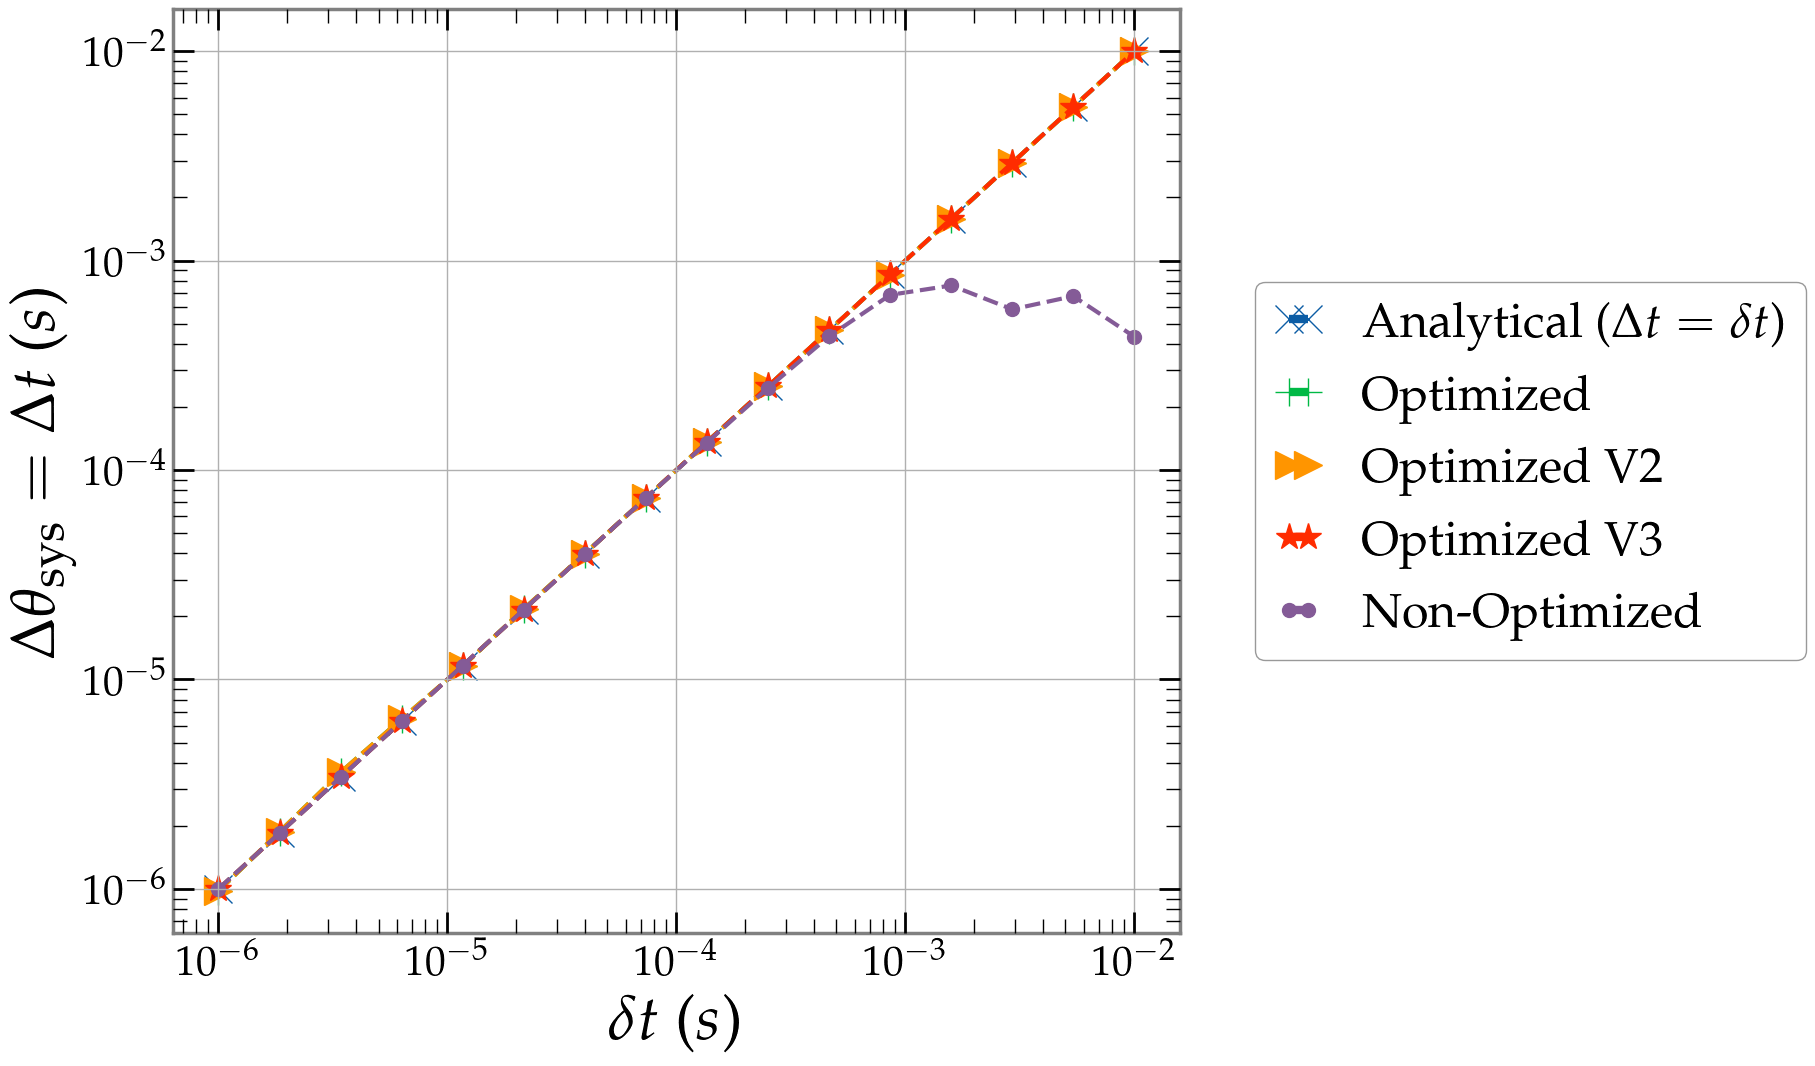

In [12]:
plt.plot(t_shifts, t_shifts, 'x--', label='Analytical ($\Delta t = \delta t$)')
plt.plot(t_shifts, t_bias_opt_v1, '+--', label='Optimized')
plt.plot(t_shifts, t_bias_opt_v2, '>--', label='Optimized V2')
plt.plot(t_shifts, t_bias_opt_v3, '*--', label='Optimized V3')
plt.plot(t_shifts, t_bias_non_opt, '.--', label='Non-Optimized')

plt.xlabel(r'$\delta t$ ($s$)')
plt.ylabel(r'$\Delta \theta_\mathrm{sys} = \Delta t$ ($s$)')
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.xscale('log')
plt.yscale('log')


plt.show()

By plotting log-log, we obtain the same shape as Potsdam paper (good)


Here are a few notes on the calculation:

- we only obtain the Potsdam paper results in the same manner when looking at Fisher matrix for time only, not time and phase. This is because point in parameter space seems to have influence on the relative proportions of bias between phase and time (changing has no effect if we shift for time as only parameter, but does have for time and phase as parameters)

- we only obtain perfect agreement in optimized case if we optimize over both time and phase, not just time (for smaller biases at least) and if both are also included in the analysis


Maybe things are harder to distinguish in mismatch for small time shifts? If accuracy we can infer these shifts with is on the order of 1e-6, then this will work fine for shifts of 1e-3, but not be visible for shifts on this order. Maybe balanced by phase?

-> former is definitely true, we had set precision of dt in phase estimation to 1e-5; testing with 1e-6

-> ahhh, indeed gets better with min_dt_prec

*Note*: in order to recover very small biases in $t_0$, we might have to select a very suitable min_dt_prec (otherwise the accuracy in the results might simply be too small to rely on it)

## Recovering $t_0$ and $\phi_0$ bias

In [13]:
t_shift = 1e-5*u.s
phi_shift = 1e-2*u.rad

def shifted_wf_gen(wf_params):
    wf = ref_generator(wf_params)
    return wf * np.exp(-2.j*np.pi*wf.frequencies*t_shift + 1.j*phi_shift)

In [14]:
wf1_shifted, wf2_shifted, opt_params = optimize_overlap(
    wf_params | {'deltaF': 2**-2*u.Hz},
    shifted_wf_gen,
    ref_generator,
    opt_params=['time', 'phase'],
    # opt_params=['time'],
    # Need very small to have very good accuracy. Balance computational cost by decreasing df
    min_dt_prec=1e-6,
    # min_dt_prec=1e-7,  # Great accuracy, but takes pretty long
    df=2**-2
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [15]:
fisher_t_bias = FisherMatrix(
    wf_params,
    ['time', 'phase'],
    # 'time',
    ref_generator,
    direct_computation=False,
    min_dt_prec=1e-5*u.s
)

sys_bias_t_bias_non_opt = fisher_t_bias.systematic_bias(
    shifted_wf_gen,
    optimize=False
)


sys_bias_t_bias_opt, opt_info = fisher_t_bias.systematic_bias(
    shifted_wf_gen,
    optimize=True,
    return_opt_info=True
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [16]:
print(t_shift, phi_shift)
print(opt_params['time'], opt_params['phase'])
print(sys_bias_t_bias_non_opt)
print(sys_bias_t_bias_opt)

1e-05 s 0.01 rad
9.5367431640625e-06 s 0.009856713809962456 rad
array([[<Quantity 9.99986923e-06 s>],
       [<Quantity 0.00999989>]], dtype=object)
array([[<Quantity 9.99999651e-06 s>],
       [<Quantity 0.01>]], dtype=object)


## Recovering $M$-Bias

In [17]:
ref_model = 'IMRPhenomXPHM'

ref_generator = get_wf_generator(ref_model)

/home/user/miniconda3/envs/gw_signal_tools_light/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


In [18]:
M_shift = 0.2*u.Msun
# M_shift = 2.*u.Msun

def shifted_wf_gen(wf_params):
    return ref_generator(wf_params | {'total_mass': wf_params['total_mass'] - M_shift})

In [19]:
wf1_shifted, wf2_shifted, opt_params = optimize_overlap(
    wf_params,
    ref_generator,
    shifted_wf_gen,
    # opt_params=['total_mass']
    opt_params=['total_mass', 'time', 'phase']
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

When including time and phase in the optimization, the mismatch as a function of $M$-shift is much smoother and does not oscillate, so that higher shifts can be recovered.

In [20]:
fisher_M_bias = FisherMatrix(
    wf_params,
    # 'total_mass',
    ['total_mass', 'time', 'phase'],
    shifted_wf_gen,
    direct_computation=False
)

sys_bias_M_bias_non_opt = fisher_M_bias.systematic_bias(
    ref_generator,
    optimize=False
)


sys_bias_M_bias_opt, opt_info = fisher_M_bias.systematic_bias(
    ref_generator,
    optimize=['time', 'phase'],
    return_opt_info=True
)


sys_bias_M_bias_M_opt, M_opt_info = fisher_M_bias.systematic_bias(
    ref_generator,
    optimize=['total_mass', 'time', 'phase'],
    return_opt_info=True
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [21]:
print(M_shift)
print(opt_params['total_mass'] - wf_params['total_mass'])
print(sys_bias_M_bias_non_opt[0,0])
print(sys_bias_M_bias_opt[0,0])
print(sys_bias_M_bias_M_opt[0,0])

0.2 solMass
0.1999664306640625 solMass
0.186571007541817 solMass
0.1970631037149894 solMass
0.20000058955234185 solMass


All of these shifts are equal to the expected shift of $$\Delta \theta_\mathrm{sys} = \theta_\mathrm{bf} - \theta_\mathrm{true} = 0.2$$

We can see that this is the correct result by remembering that the injected reference signal has $M = 50 M_\odot$. The biased model will achieve the best fit with this when it returns the waveform for $M = 50 M_\odot$, which is the case for input $50 M_\odot + \text{shift}$. This is nothing but the $M$-component of $\theta_\mathrm{bf}$.

In [22]:
M_shift_from_opt = []
M_bias_non_opt = []
M_bias_opt = []
M_bias_M_opt = []

# M_shifts = np.linspace(0.2, 1.25, num=10)*u.Msun
M_shifts = np.linspace(1e-2, 0.8, num=10)*u.Msun


wf1 = ref_generator(wf_params)

for shift in M_shifts:
    def shifted_wf_gen(wf_params):
        return ref_generator(wf_params | {'total_mass': wf_params['total_mass'] - shift})

    _, _, opt_params = optimize_overlap(
        wf_params,
        ref_generator,
        shifted_wf_gen,
        # opt_params=['total_mass']
        opt_params=['total_mass', 'time', 'phase']
    )

    M_shift_from_opt += [
        (opt_params['total_mass'] - wf_params['total_mass']).value  # Otherwise error when reshaping
    ]
    # Kind of unnecessary, optimization in sys error does same
    
    fisher_M_bias = FisherMatrix(
        wf_params,
        # 'total_mass',
        ['total_mass', 'time', 'phase'],
        shifted_wf_gen,
        direct_computation=False
    )

    M_bias_non_opt += [
        fisher_M_bias.systematic_bias(
            ref_generator,
            'total_mass',
            optimize=False
        )
    ]

    M_bias_opt += [
        fisher_M_bias.systematic_bias(
            ref_generator,
            'total_mass',
            optimize=['time', 'phase'],
            return_opt_info=False
        )
    ]

    M_bias_M_opt += [
        fisher_M_bias.systematic_bias(
            ref_generator,
            'total_mass',
            optimize=['total_mass', 'time', 'phase'],
            return_opt_info=False
        )
    ]

M_shift_from_opt = np.reshape(M_shift_from_opt, -1)
M_bias_non_opt = np.reshape(M_bias_non_opt, -1)
M_bias_opt = np.reshape(M_bias_opt, -1)
M_bias_M_opt = np.reshape(M_bias_M_opt, -1)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

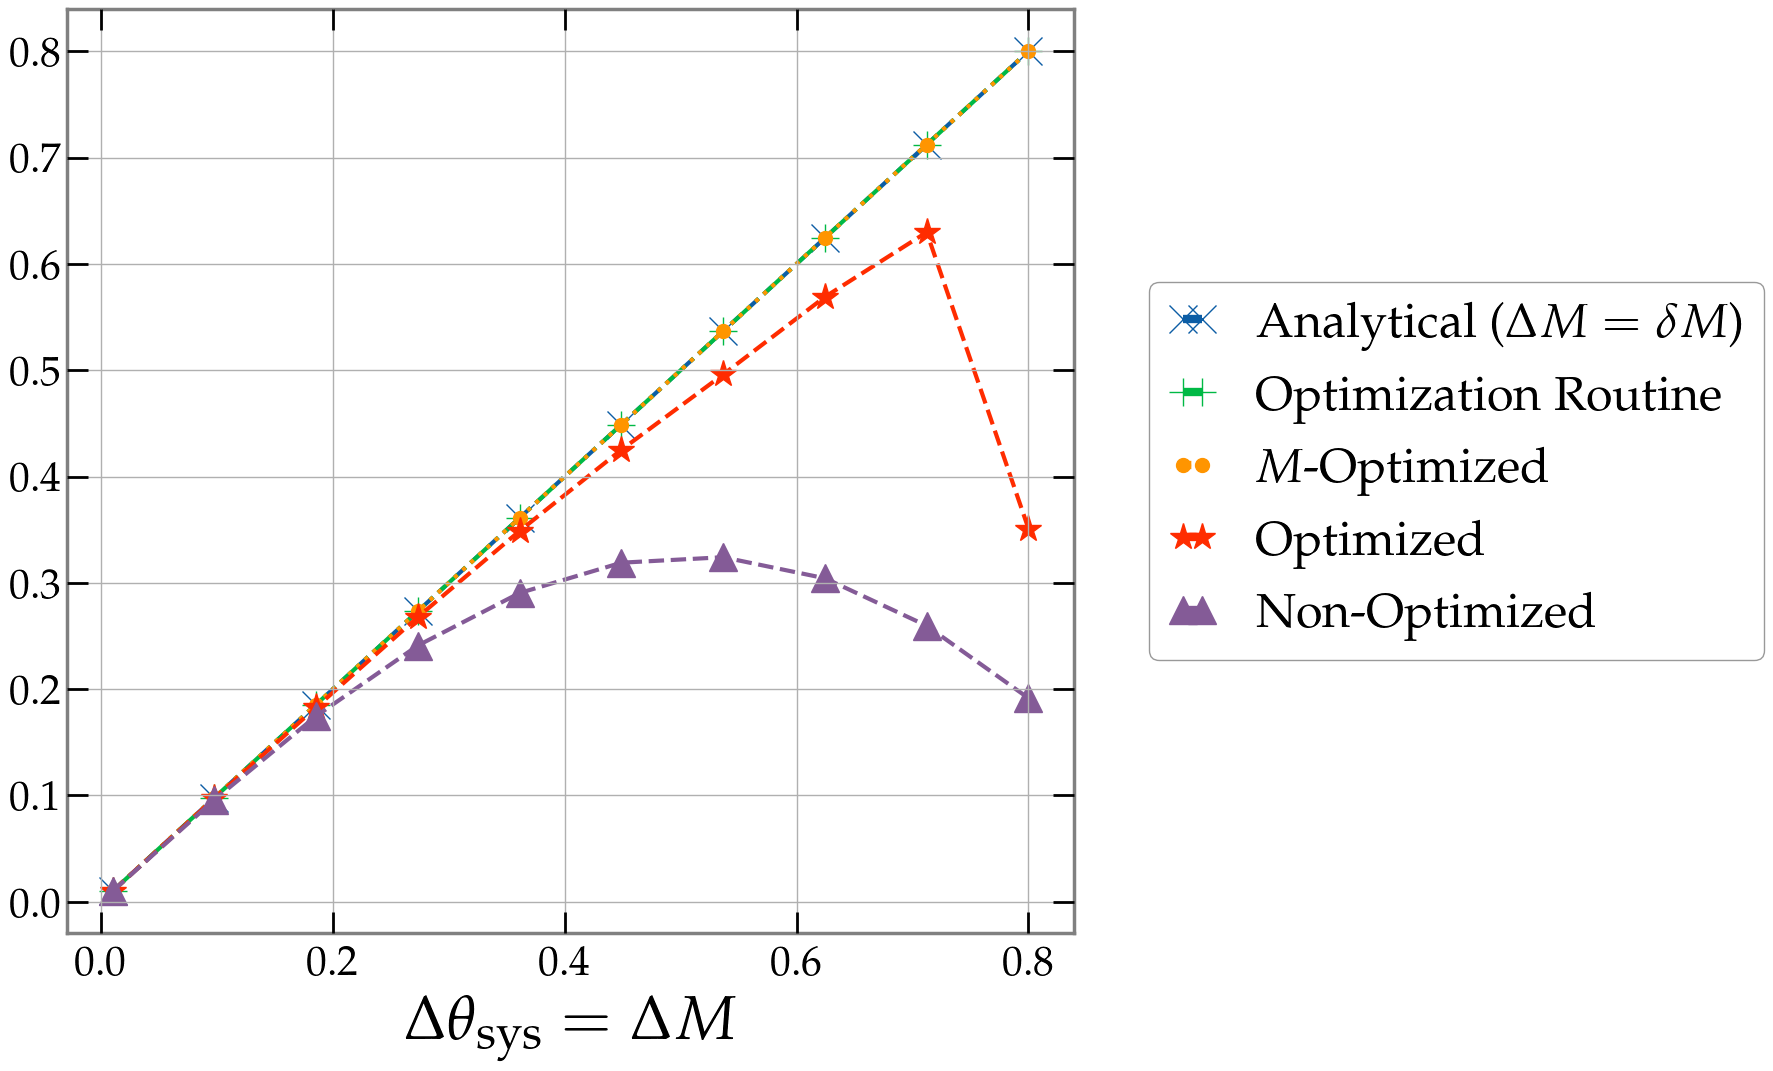

In [23]:
plt.plot(M_shifts, M_shifts, 'x--', label='Analytical ($\Delta M = \delta M$)')
plt.plot(M_shifts, M_shift_from_opt, '+-.', label='Optimization Routine')
plt.plot(M_shifts, M_bias_M_opt, '.:', label='$M$-Optimized')
plt.plot(M_shifts, M_bias_opt, '*--', label='Optimized')
plt.plot(M_shifts, M_bias_non_opt, '^--', label='Non-Optimized')

plt.xlabel(r'$\delta M$')
plt.xlabel(r'$\Delta \theta_\mathrm{sys} = \Delta M$')
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.show()

These curves are pretty much expected in that manner. For small biases, all formulas work reasonably well. Optimized one works better than non-optimized. Optimizing over $M$ in the systematic error calculation yields exact results.

## Recovering $M$-Bias in Multiple Detectors

In [24]:
ref_model = 'IMRPhenomXPHM'

ref_generator = get_wf_generator(ref_model)

In [25]:
from gw_signal_tools.types import Detector
from gw_signal_tools.PSDs import psd_no_noise, psd_o3_h1, psd_o3_l1, psd_o3_v1


# psd_o3_h1 = psd_no_noise
# psd_o3_l1 = psd_no_noise
# psd_o3_v1 = psd_no_noise

hanford = Detector('H1', psd_o3_h1)
livingston = Detector('L1', psd_o3_l1)
virgo = Detector('V1', psd_o3_v1)

ext_params = {
    'ra': 0.2*u.rad,
    'dec': 0.2*u.rad,
    'psi': 0.5*u.rad,
    'tgps': 1126259462,
}

In [26]:
# Testing with increased SNR
wf_params['distance'] = 1.*u.Mpc

In [27]:
# M_shift = 0.2*u.Msun
M_shift = 0.4*u.Msun
# M_shift = 0.6*u.Msun

def shifted_wf_gen(wf_params):
    return ref_generator(wf_params | {'total_mass': wf_params['total_mass'] - M_shift})

When including time and phase in the optimization, the mismatch as a function of $M$-shift is much smoother and does not oscillate, so that higher shifts can be recovered.

In [28]:
fisher_M_bias_multi = FisherMatrixNetwork(
    wf_params | ext_params,
    # 'total_mass',
    ['total_mass', 'time', 'phase'],
    shifted_wf_gen,
    [hanford, livingston],
    # [hanford, livingston, virgo],
    direct_computation=False,
    f_range=[f_min, f_max]
)

sys_bias_M_bias_multi_non_opt = fisher_M_bias_multi.systematic_bias(
    ref_generator,
    optimize=False
)


sys_bias_M_bias_multi_opt, opt_info_multi = fisher_M_bias_multi.systematic_bias(
    ref_generator,
    optimize=['time', 'phase'],
    return_opt_info=True
)


# sys_bias_M_bias_multi_M_opt, M_opt_info_multi = fisher_M_bias_multi.systematic_bias(
#     ref_generator,
#     optimize=['total_mass', 'time', 'phase'],
#     return_opt_info=True
# )

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [29]:
print(M_shift)
print(sys_bias_M_bias_multi_non_opt[0,0])
print(sys_bias_M_bias_multi_opt[0,0])
# print(sys_bias_M_bias_multi_M_opt[0,0])

0.4 solMass
0.15636093484125382 solMass
0.37316127642083013 solMass


Single detector values for comparison

In [30]:
fisher_M_bias_h1 = FisherMatrix(
    wf_params | ext_params | {'det': 'H1'},
    # 'total_mass',
    ['total_mass', 'time', 'phase'],
    shifted_wf_gen,
    direct_computation=False,
    psd=psd_o3_h1,
    f_range=[f_min, f_max]
)

sys_bias_M_bias_non_opt_h1 = fisher_M_bias_h1.systematic_bias(
    ref_generator,
    optimize=False
)


sys_bias_M_bias_opt_h1 = fisher_M_bias_h1.systematic_bias(
    ref_generator,
    optimize=['time', 'phase']
)


# sys_bias_M_bias_M_opt_h1 = fisher_M_bias_h1.systematic_bias(
#     ref_generator,
#     optimize=['total_mass', 'time', 'phase']
# )


fisher_M_bias_l1 = FisherMatrix(
    wf_params | ext_params | {'det': 'L1'},
    # 'total_mass',
    ['total_mass', 'time', 'phase'],
    shifted_wf_gen,
    direct_computation=False,
    psd=psd_o3_l1,
    f_range=[f_min, f_max]
)

sys_bias_M_bias_non_opt_l1 = fisher_M_bias_l1.systematic_bias(
    ref_generator,
    optimize=False
)


sys_bias_M_bias_opt_l1 = fisher_M_bias_l1.systematic_bias(
    ref_generator,
    optimize=['time', 'phase']
)


# sys_bias_M_bias_M_opt_l1 = fisher_M_bias_l1.systematic_bias(
#     ref_generator,
#     optimize=['total_mass', 'time', 'phase']
# )

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [31]:
print(M_shift)
print(sys_bias_M_bias_non_opt_h1[0,0])
print(sys_bias_M_bias_opt_h1[0,0])
print(sys_bias_M_bias_non_opt_l1[0,0])
print(sys_bias_M_bias_opt_l1[0,0])
print(sys_bias_M_bias_multi_non_opt[0,0])
print(sys_bias_M_bias_multi_opt[0,0])

0.4 solMass
0.03541038661085591 solMass
0.385837453630004 solMass
0.1858617786812468 solMass
0.38034156658314894 solMass
0.15636093484125382 solMass
0.37316127642083013 solMass


For no noise case, multiple detectors do not help much. In fact, there is not too much improvement for real PSDs either, that is really interesting... Values for optimized case are consistently slightly worse than single detector estimates...

In [32]:
print(fisher_M_bias_multi.snr())
print(fisher_M_bias_h1.snr())
print(fisher_M_bias_l1.snr())

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

21281.933145898198


XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

13904.397539945574
16111.747499189398


XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [33]:
print(fisher_M_bias_multi.cond())
print((fisher_M_bias_multi.fisher @ fisher_M_bias_multi.fisher_inverse).value)

print(fisher_M_bias_h1.cond())
print((fisher_M_bias_h1.fisher @ fisher_M_bias_h1.fisher_inverse).value)

print(fisher_M_bias_l1.cond())
print((fisher_M_bias_l1.fisher @ fisher_M_bias_l1.fisher_inverse).value)

51645775.44837741
[[ 1.00000000e+00 -3.09171822e-19  3.99374173e-15]
 [-8.04405307e-13  1.00000000e+00 -3.17951347e-12]
 [-7.03822381e-16  2.47122124e-18  1.00000000e+00]]
134460644.7615174
[[ 1.00000000e+00 -6.29229977e-19  6.55286163e-14]
 [ 3.33295108e-12  1.00000000e+00  2.53811625e-11]
 [-6.75237057e-15  1.21804628e-18  1.00000000e+00]]
33046973.397483405
[[ 1.00000000e+00  9.03232894e-18 -1.95253914e-14]
 [-9.09358245e-14  1.00000000e+00  7.35874724e-13]
 [-3.79314494e-15  1.47395336e-18  1.00000000e+00]]


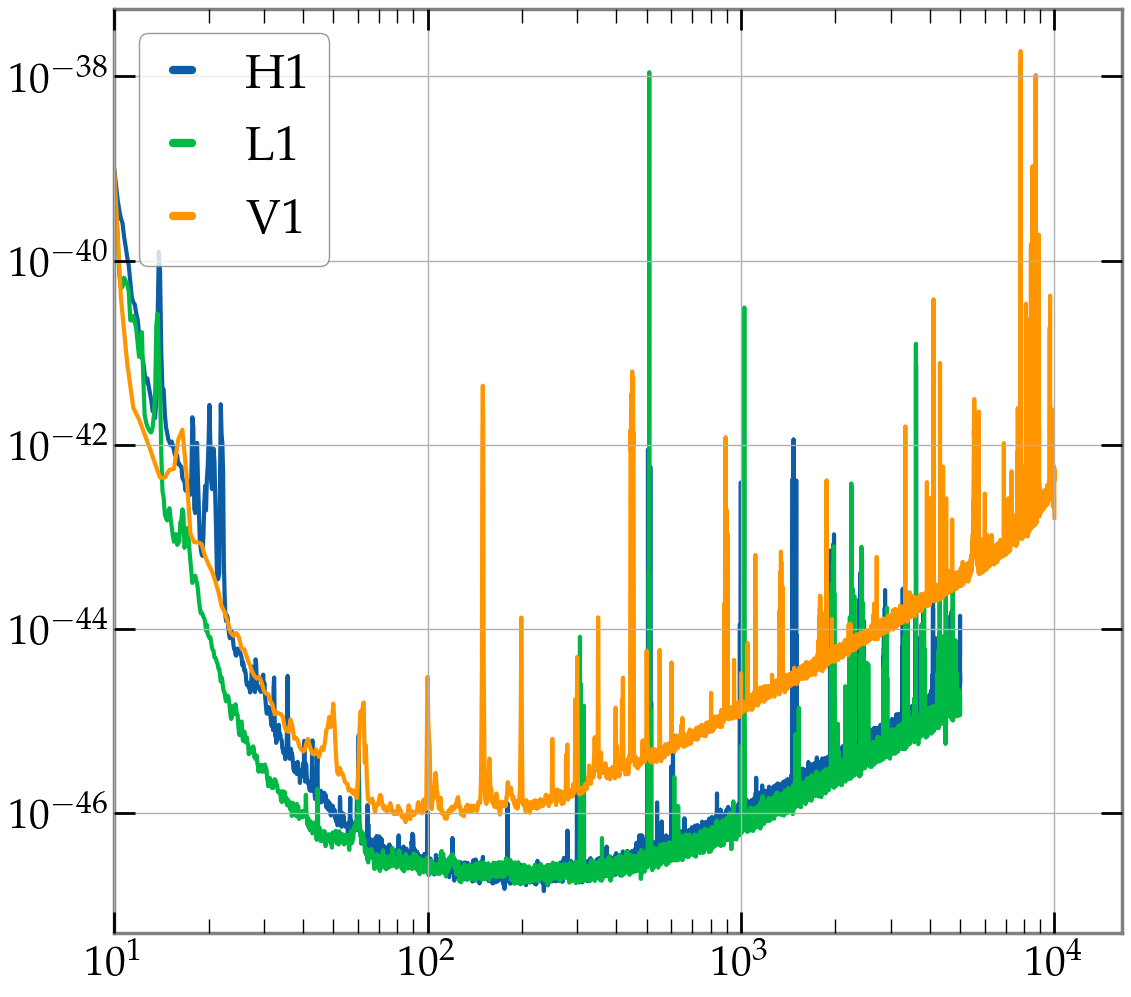

In [34]:
plt.plot(psd_o3_h1, label='H1')
plt.plot(psd_o3_l1, label='L1')
plt.plot(psd_o3_v1, label='V1')

plt.loglog()
plt.legend()

plt.xlim(left=10)

plt.show()

Ok, now trend of Livingston producing more faithful results makes more sense, for relevant frequencies between 10 and 100 Hz, it has lower noise.

-> increase of SNR helps with that, though, nice

## Benchmarking

In [35]:
import cProfile

In [36]:
cProfile.run(
    '''optimize_overlap(
        wf_params,
        ref_generator,
        shifted_wf_gen,
        # opt_params=['total_mass']
        opt_params=['total_mass', 'time', 'phase']
    )''',
    sort=1
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

         1073350 function calls (1065331 primitive calls) in 9.955 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       34    2.791    0.082    2.798    0.082 {built-in method lalsimulation._lalsimulation.SimInspiralGenerateFDWaveform}
      646    2.512    0.004    2.512    0.004 {built-in method lal._lal.DictInsertREAL8Value}
       68    0.525    0.008    0.801    0.012 array.py:319(epoch)
       34    0.400    0.012    8.027    0.236 waveform.py:334(generate_fd_waveform)
       68    0.275    0.004    0.276    0.004 _tconvert.py:96(to_gps)
       68    0.270    0.004    0.270    0.004 {built-in method lalsimulation._lalsimulation.SimInspiralImplementedFDApproximants}
       68    0.266    0.004    1.112    0.016 waveform.py:525(to_gwpy_Series)
       68    0.264    0.004    0.264    0.004 {built-in method lalsimulation._lalsimulation.SimInspiralImplementedTDApproximants}
       34    0.137    0.004    0.137    0.004 {

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is